# Softmax exercise

In [15]:
%matplotlib inline
import numpy as np
from keras.datasets import mnist
from sklearn.model_selection import StratifiedShuffleSplit
import time
from random import randrange
from past.builtins import xrange
import matplotlib.pyplot as plt
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

X_train original shape (60000, 28, 28)
y_train original shape (60000,)
X_test original shape (10000, 28, 28)
y_test original shape (10000,)
class	count
0	5923
1	6742
2	5958
3	6131
4	5842
5	5421
6	5918
7	6265
8	5851
9	5949


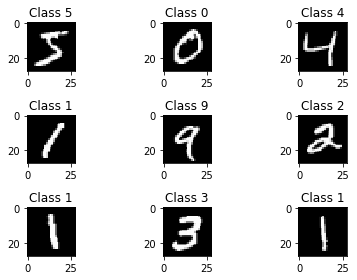

In [16]:
nb_classes = 10
(X_train, y_train), (X_test, y_test) = mnist.load_data()

#############################################################################
# TODO: Print the shape of the training data and testing data               #
# Plot the previous 9 training data and title their class                   #
# Count the number of data for each class in training data                  #
#############################################################################
print("X_train original shape {}".format(X_train.shape))
print("y_train original shape {}".format(y_train.shape))
print("X_test original shape {}".format(X_test.shape))
print("y_test original shape {}".format(y_test.shape))

for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(X_train[i], cmap = 'gray', interpolation = 'none')
    plt.title("Class {}".format(y_train[i]))
plt.tight_layout()
    
unique, count = np.unique(y_train, return_counts = True)
cls_count = np.concatenate((unique.reshape(nb_classes, 1), count.reshape(nb_classes, 1)), axis = 1)
print('class\tcount')
print('\n'.join(['{}\t{}'.format(item[0], item[1]) for item in cls_count]))
# for cls in cls_count:
#     print('{}\t{}'.format(str(cls[0]), str(cls[1])))
#############################################################################
#                          END OF YOUR CODE                                 #
#############################################################################



In [17]:
# data prepration for binary classification
not_n = 1
def get_mnist_data(X_train, y_train, X_test, y_test):
    # normalization
    X_train = X_train.reshape((X_train.shape[0], -1)) / 255.
    X_test = X_test.reshape((X_test.shape[0], -1)) / 255.
    
    # binarize
    y_train[y_train != not_n] = 0
    y_train[y_train == not_n] = 1
    y_test[y_test != not_n] = 0
    y_test[y_test == not_n] = 1
    
    X = np.array(X_train)
    y = np.array(y_train)
    
    # split train and validation
    sss = StratifiedShuffleSplit(n_splits = 10, test_size = 0.5, random_state = 0)
    for train_idx, val_idx in sss.split(X_train, y_train):
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    
    X_train, y_train = subsampling(X_train, y_train)
    X_val, y_val = subsampling(X_val, y_val)
    X_test, y_test = subsampling(X_test, y_test)
    
    return X_train, y_train, X_val, y_val , X_test, y_test

def subsampling(X, y):
    unique, count = np.unique(y, return_counts = True)
    n_sampling = count[np.argmin(count)]
    
    idx_list = []
    for i in range(len(unique)):
        if count[i] <= n_sampling:
            idx_list.append(np.where(y == unique[i])[0])
            continue
        idx = np.where(y == unique[i])[0]
        idx = np.random.choice(idx, n_sampling, replace = False)
        idx_list.append(idx)
    
    all_idx = np.sort(np.concatenate(idx_list))
    X_sub = X[all_idx]
    y_sub = y[all_idx]
    
    return X_sub, y_sub

# Invoke the above function to get our data
X_train, y_train, X_val, y_val, X_test, y_test = get_mnist_data(X_train, y_train, X_test, y_test)
print('Train data shape: {}'.format(X_train.shape))
print('Train label shape: {}'.format(y_train.shape))
print('Validation data shape: {}'.format(X_val.shape))
print('Validation label shape: {}'.format(y_val.shape))
print('Test data shape: {}'.format(X_test.shape))
print('Test label shape: {}'.format(y_test.shape))

Train data shape: (6742, 785)
Train label shape: (6742,)
Validation data shape: (6742, 785)
Validation label shape: (6742,)
Test data shape: (2270, 785)
Test label shape: (2270,)


# Softmax

In [18]:
# First implement the naive softmax loss function with nested loops
def softmax_loss_naive(W, X, y, reg):
    
  """
  Softmax loss function, naive implementation (with loops)

  Inputs have dimension D, there are C classes, and we operate on minibatches
  of N examples.

  Inputs:
  - W: A numpy array of shape (D, C) containing weights.
  - X: A numpy array of shape (N, D) containing a minibatch of data.
  - y: A numpy array of shape (N,) containing training labels; y[i] = c means
    that X[i] has label c, where 0 <= c < C.
  - reg: (float) regularization strength

  Returns a tuple of:
  - loss as single float
  - gradient with respect to weights W; an array of same shape as W
  """
  # Initialize the loss and gradient to zero.
  loss = 0.0
  dW = np.zeros_like(W)

  #############################################################################
  # TODO: Compute the softmax loss and its gradient using explicit loops.     #
  # Store the loss in loss and the gradient in dW. If you are not careful     #
  # here, it is easy to run into numeric instability. Don't forget the        #
  # regularization!                                                           #
  #############################################################################
  N = X.shape[0]
  D = X.shape[1]
  C = W.shape[1]
  data_loss = 0.0
  
  prob = np.zeros((N, C))
  for i in range(N):
    score = np.zeros((C))
    for j in range(C):
      score[j] = np.sum(X[i] * W[:, j])
    exp_score = np.exp(score)
    prob[i] = exp_score / np.sum(exp_score)
  
  for i in range(N):
    correct_logprob = - np.log(prob[i, y[i]])
    data_loss += correct_logprob
  reg_loss = 0.0
  for i in range(D):
    for j in range(C):
      reg_loss += W[i, j] ** 2
  reg_loss *= 0.5 * reg
  loss = data_loss / N + reg_loss
  
  dscore = np.array(prob)
  for i in range(N):
    dscore[i, y[i]] -= 1
  # dscore[range(N), y] not dscore[:, y]
  dscore /= N
  for i in range(D):
    for j in range(C):
      dW[i, j] = np.sum(X[:, i] * dscore[:, j])
      if i != D - 1:
        dW[i, j] += reg * W[i, j]
  #############################################################################
  #                          END OF YOUR CODE                                 #
  #############################################################################

  return loss, dW

In [19]:
# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(785, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_train, y_train, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.302628
sanity check: 2.302585


## Inline Question 1:
Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

**Your answer:** *Since there are 10 classes, a randomly-initialized weight will predict each class with probability 0.1*

In [27]:
# Use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
def grad_check_sparse(f, x, analytic_grad, num_checks=10, h=1e-5):
  """
  sample a few random elements and only return numerical
  in this dimensions.
  """

  for i in xrange(num_checks):
    ix = tuple([randrange(m) for m in x.shape])

    oldval = x[ix]
    x[ix] = oldval + h # increment by h
    fxph = f(x) # evaluate f(x + h)
    x[ix] = oldval - h # increment by h
    fxmh = f(x) # evaluate f(x - h)
    x[ix] = oldval # reset

    grad_numerical = (fxph - fxmh) / (2 * h)
    grad_analytic = analytic_grad[ix]
    rel_error = abs(grad_numerical - grad_analytic) / (abs(grad_numerical) + abs(grad_analytic) + 10 ** -8)
    print('numerical: %f analytic: %f, relative error: %e' % (grad_numerical, grad_analytic, rel_error))


f = lambda w: softmax_loss_naive(w, X_train, y_train, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# Do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_train, y_train, 5e1)
f = lambda w: softmax_loss_naive(w, X_train, y_train, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: 0.000057 analytic: 0.002742, relative error: 9.596021e-01
numerical: 0.001428 analytic: -0.004319, relative error: 9.999983e-01
numerical: 0.000038 analytic: -0.002282, relative error: 9.999957e-01
numerical: 0.033055 analytic: 0.030680, relative error: 3.726030e-02
numerical: 0.000013 analytic: 0.004838, relative error: 9.948409e-01
numerical: 0.000789 analytic: 0.008150, relative error: 8.234574e-01
numerical: 0.000003 analytic: -0.002346, relative error: 9.999957e-01
numerical: 0.001808 analytic: 0.000977, relative error: 2.986024e-01
numerical: 0.020913 analytic: 0.022593, relative error: 3.861060e-02
numerical: -0.000207 analytic: -0.009691, relative error: 9.582122e-01
numerical: 0.007670 analytic: 0.007670, relative error: 3.092886e-09
numerical: -0.003231 analytic: -0.003231, relative error: 1.780195e-08
numerical: 0.006271 analytic: 0.006271, relative error: 6.052792e-10
numerical: 0.001502 analytic: 0.001502, relative error: 2.719138e-09
numerical: 0.002243 analyti

In [28]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_train, y_train, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

naive loss: 2.302628e+00 computed in 1.488722s


In [29]:
def softmax_loss_vectorized(W, X, y, reg):
  """
  Softmax loss function, vectorized version.

  Inputs and outputs are the same as softmax_loss_naive.
  """
  # Initialize the loss and gradient to zero.
  loss = 0.0
  dW = np.zeros_like(W)

  #############################################################################
  # TODO: Compute the softmax loss and its gradient using no explicit loops.  #
  # Store the loss in loss and the gradient in dW. If you are not careful     #
  # here, it is easy to run into numeric instability. Don't forget the        #
  # regularization!                                                           #
  #############################################################################
  N = X.shape[0]
  D = X.shape[1]
  C = W.shape[1]
  data_loss = 0.0
  
  scores = np.dot(X, W)
  exp_scores = np.exp(scores)
  probs = exp_scores / np.sum(exp_scores, axis = 1, keepdims = True) # keepdims: broadcast
  correct_logprobs = - np.log(probs[range(N), y]) # range(N)
  data_loss += np.sum(correct_logprobs) / N
  
  reg_loss = 0.5 * reg * np.sum(W * W)
  loss = data_loss + reg_loss
  
  dscores = probs
  dscores[range(N), y] -= 1
  dscores /= N
  dW = np.dot(X.T, dscores)
  dW[:, :-1] += reg * W[:, :-1]
  #############################################################################
  #                          END OF YOUR CODE                                 #
  #############################################################################

  return loss, dW

In [30]:
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_train, y_train, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# We use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord = 'fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

vectorized loss: 2.302628e+00 computed in 0.028544s
Loss difference: 0.000000
Gradient difference: 0.000000


In [31]:
class LinearClassifier(object):

  def __init__(self):
    self.W = None

  def train(self, X, y, learning_rate=1e-3, reg=1e-5, num_iters=100,
            batch_size=200, verbose=False):
    """
    Train this linear classifier using stochastic gradient descent.

    Inputs:
    - X: A numpy array of shape (N, D) containing training data; there are N
      training samples each of dimension D.
    - y: A numpy array of shape (N,) containing training labels; y[i] = c
      means that X[i] has label 0 <= c < C for C classes.
    - learning_rate: (float) learning rate for optimization.
    - reg: (float) regularization strength.
    - num_iters: (integer) number of steps to take when optimizing
    - batch_size: (integer) number of training examples to use at each step.
    - verbose: (boolean) If true, print progress during optimization.

    Outputs:
    A list containing the value of the loss function at each training iteration.
    """
    num_train, dim = X.shape
    num_classes = np.max(y) + 1 # assume y takes values 0...K-1 where K is number of classes
    if self.W is None:
      # lazily initialize W
      self.W = 0.001 * np.random.randn(dim, num_classes)

    # Run stochastic gradient descent to optimize W
    loss_history = []
    for it in xrange(num_iters):
      X_batch = None
      y_batch = None

      #########################################################################
      # TODO:                                                                 #
      # Sample batch_size elements from the training data and their           #
      # corresponding labels to use in this round of gradient descent.        #
      # Store the data in X_batch and their corresponding labels in           #
      # y_batch; after sampling X_batch should have shape (dim, batch_size)   #
      # and y_batch should have shape (batch_size,)                           #
      #                                                                       #
      # Hint: Use np.random.choice to generate indices. Sampling with         #
      # replacement is faster than sampling without replacement.              #
      #########################################################################
      idx = np.random.choice(range(num_train), batch_size, replace = False)
      X_batch = X[idx]
      y_batch = y[idx]
      #########################################################################
      #                       END OF YOUR CODE                                #
      #########################################################################

      # evaluate loss and gradient
      loss, grad = self.loss(X_batch, y_batch, reg)
      loss_history.append(loss)

      # perform parameter update
      #########################################################################
      # TODO:                                                                 #
      # Update the weights using the gradient and the learning rate.          #
      #########################################################################
      self.W += - learning_rate * grad
      #########################################################################
      #                       END OF YOUR CODE                                #
      #########################################################################

      if verbose and it % 100 == 0:
        print('iteration %d / %d: loss %f' % (it, num_iters, loss))

    return loss_history

  def predict(self, X):
    """
    Use the trained weights of this linear classifier to predict labels for
    data points.

    Inputs:
    - X: A numpy array of shape (N, D) containing training data; there are N
      training samples each of dimension D.

    Returns:
    - y_pred: Predicted labels for the data in X. y_pred is a 1-dimensional
      array of length N, and each element is an integer giving the predicted
      class.
    """
    y_pred = np.zeros(X.shape[0])
    ###########################################################################
    # TODO:                                                                   #
    # Implement this method. Store the predicted labels in y_pred.            #
    ###########################################################################
    scores = np.dot(X, self.W)
    y_pred = np.argmax(scores, axis = 1)
    ###########################################################################
    #                           END OF YOUR CODE                              #
    ###########################################################################
    return y_pred
  
  def loss(self, X_batch, y_batch, reg):
    """
    Compute the loss function and its derivative. 
    Subclasses will override this.

    Inputs:
    - X_batch: A numpy array of shape (N, D) containing a minibatch of N
      data points; each point has dimension D.
    - y_batch: A numpy array of shape (N,) containing labels for the minibatch.
    - reg: (float) regularization strength.

    Returns: A tuple containing:
    - loss as a single float
    - gradient with respect to self.W; an array of the same shape as W
    """
    pass

class Softmax(LinearClassifier):
  """ A subclass that uses the Softmax + Cross-entropy loss function """

  def loss(self, X_batch, y_batch, reg):
    return softmax_loss_vectorized(self.W, X_batch, y_batch, reg)

In [32]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.6 on the validation set.
results = {}
best_val = -1
best_softmax = None
learning_rates = [1e-6, 5e-6]
regularization_strengths = [2.5e4, 5e4]

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# save the best trained softmax classifer in best_softmax.                     #
################################################################################
for lr in learning_rates:
    for rs in regularization_strengths:
        clf = Softmax()
        clf.train(X_train, y_train, lr, rs, num_iters = 1000, batch_size = 200)
        y_pred_train = clf.predict(X_train)
        train_acc = np.mean(y_pred_train == y_train)
        y_pred = clf.predict(X_val)
        val_acc = np.mean(y_pred == y_val)
        if val_acc > best_val:
          best_val = val_acc
          best_softmax = clf
        results[(lr, rs)] = train_acc, val_acc
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

lr 1.000000e-06 reg 2.500000e+04 train accuracy: 0.408484 val accuracy: 0.410857
lr 1.000000e-06 reg 5.000000e+04 train accuracy: 0.603975 val accuracy: 0.608721
lr 5.000000e-06 reg 2.500000e+04 train accuracy: 0.937704 val accuracy: 0.935627
lr 5.000000e-06 reg 5.000000e+04 train accuracy: 0.917384 val accuracy: 0.917532
best validation accuracy achieved during cross-validation: 0.935627


In [33]:
# evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.941850


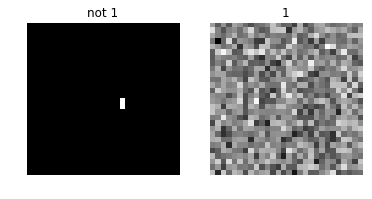

In [34]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(28, 28, 2)

w_min, w_max = np.min(w), np.max(w)

classes = ['not {}'.format(not_n), '{}'.format(not_n)]
for i in range(2):
    plt.subplot(1, 2, i + 1)
    
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])